## Importing Modules

In [2]:
import IPython
import wave
from sklearn import *
import pickle
from tqdm import tqdm as tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from numpy import exp as exp
import scipy
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
warnings.filterwarnings("ignore")
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="darkgrid", rc=custom_params)

# Question 1

## ICA from scratch

In [858]:
class ica:
    def __init__(self,components = 3):
        self.components = components
        self.means = None
        self.wMatrix = None
        self.signals = components
    def tanh(self,x,der = False):
        if der:
            return  1 - np.tanh(x)*np.tanh(x)
        return np.tanh(x)
    def center(self,X_):
        X = X_.copy()
        mean = np.mean(X,axis = 1).reshape(X.shape[0],1)
        return X-mean
    def covarianceMatrix(self,X):
        mean = np.mean(X,axis = 1).reshape(X.shape[0],1)
        p = X-mean
        return p.dot(p.T) / p.shape[1]-1
    def whiten(self,X):
        covMatrix = np.cov(X)
        ev, E = np.linalg.eig(covMatrix)
        D = np.zeros((len(ev),len(ev)))
        for i in range(D.shape[0]):
            D[i][i] = ev[i]
        D_inv = np.sqrt(np.linalg.inv(D))
        X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
        return X_whiten
    def wUpdate(self,w,X):
        w_new = (X * self.tanh(np.dot(w.T, X))).mean(axis=1) - self.tanh(np.dot(w.T, X), True).mean() * w
        return w_new /np.sqrt((w_new ** 2).sum())
    def tolerance(self,x,y,signals=3):
        sum_ = 0
        for ix,i in enumerate(x):
            sum_ += x[ix]*y[ix]
        return abs(sum_-1)
    def fit(self,X , iterations = 1000, threshold = 1e-10):
        signals = X.shape[0]
        self.signals = signals
        self.means = np.mean(X,axis = 1).reshape(X.shape[0],1)
        self.sd = np.std(X,axis = 1).reshape(X.shape[0],1)
        X = self.center(X)
        X = self.whiten(X)
        W = np.zeros((signals,signals)).astype('float64')
        for num in range(1):
            for signal in range(signals):
                w = np.random.standard_normal(signals)
                for it in tqdm(range(iterations)):
                    wn = self.wUpdate(w,X)
                    if signal > 0:
                        wn = wn - np.dot(np.dot(wn, W[:signal].T), W[:signal])
                    tolerance = self.tolerance(w,wn)
                    w = wn
                    if threshold > tolerance:
                        break_ = 1
                W[signal,:] = w
        self.wMatrix = W
    def transform(self,X_):
        w = self.wMatrix.copy()
        X = X_.copy()
        return w.dot(X) 
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)

## Part 1

In [92]:
PATH = ''
mix_1_wave = wave.open(PATH+'signal_1.wav','r')
mix_2_wave = wave.open(PATH+'signal_2.wav','r')
mix_3_wave = wave.open(PATH+'signal_3.wav','r')

In [93]:
signal_1_raw = mix_1_wave.readframes(-1)
signal_1 = np.fromstring(signal_1_raw, 'int16')
signal_2_raw = mix_2_wave.readframes(-1)
signal_2 = np.fromstring(signal_2_raw, 'int16')
signal_3_raw = mix_3_wave.readframes(-1)
signal_3 = np.fromstring(signal_3_raw, 'int16')

Visualising

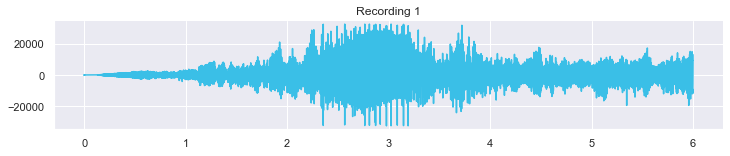

In [94]:
fs = mix_1_wave.getframerate()
timing = np.linspace(0, len(signal_1)/fs, num=len(signal_1))
plt.figure(figsize=(12,2))
plt.title('Recording 1')
plt.plot(timing,signal_1, c="#3ABFE7")
plt.ylim(-35000, 35000)
plt.show();

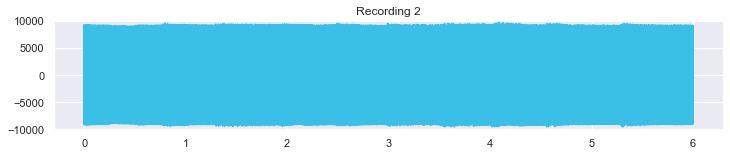

In [862]:
fs = mix_2_wave.getframerate()
timing = np.linspace(0, len(signal_2)/fs, num=len(signal_2))
plt.figure(figsize=(12,2))
plt.title('Recording 2')
plt.plot(timing,signal_2, c="#3ABFE7")
plt.ylim(-10000, 10000)
plt.show();

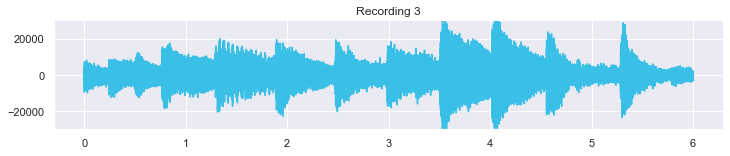

In [863]:
fs = mix_3_wave.getframerate()
timing = np.linspace(0, len(signal_3)/fs, num=len(signal_3))
plt.figure(figsize=(12,2))
plt.title('Recording 3')
plt.plot(timing,signal_3, c="#3ABFE7")
plt.ylim(-30000, 30000)
plt.show();

In [864]:
IPython.display.Audio(PATH+'signal_1.wav')

In [865]:
IPython.display.Audio(PATH+'signal_2.wav')

In [866]:
IPython.display.Audio(PATH+'signal_3.wav')

## Part 2

In [95]:
X = list(zip(signal_1, signal_2, signal_3))
df = pd.DataFrame(X)
df.columns = ['Signal '+str(i) for i in range(1,4)]

In [868]:
df

Signal 1  Signal 2  Signal 3
0            -23       -52      2142
1            -16      -624      2328
2            -28     -1178      2010
3            -11     -1740      1989
4            -25     -2282      1671
...          ...       ...       ...
264510     -8701     -5439       891
264511     -8845     -5886       986
264512     -8994     -6313      1296
264513     -9187     -6713      1332
264514     -9321     -7091      1754

[264515 rows x 3 columns]

In [99]:
A = np.random.rand(3,3)
X = df.values
max_ = np.array([np.max(X[:,i]) for i in range(3)])
X_ = X / max_
Xmix = A.dot(X_.T)
Xmix

array([[ 0.05785287,  0.03277381, -0.00571921, ..., -0.33827506,
        -0.35935265, -0.36805991],
       [ 0.03499101, -0.01494352, -0.07295102, ..., -0.70627542,
        -0.74603578, -0.77557332],
       [ 0.02565439, -0.00309586, -0.03786529, ..., -0.43845397,
        -0.46224416, -0.47892024]])

## Part 3

In [870]:
ic = ica(3) ## ICA was implemented from scratch and the class can be found above
Xrec = ic.fit_transform(Xmix)
ww = ic.wMatrix
ww.dot(np.linalg.inv(ww))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.63it/s]


array([[ 1.00000000e+00,  2.16690239e-17, -2.97124772e-17],
       [-3.13333693e-17,  1.00000000e+00, -1.19772933e-16],
       [-1.39331698e-17,  7.02000690e-18,  1.00000000e+00]])

## Part 4

In [871]:
dfRec = pd.DataFrame(Xrec.T)
dfRec.columns = ['Column '+str(i+1) for i in range(3)]

In [872]:
dfRec.head()

Column 1  Column 2  Column 3
0  0.058616  0.004454 -0.029900
1  0.064117  0.008834 -0.028358
2  0.055454  0.012310 -0.018959
3  0.055406  0.016164 -0.014842
4  0.046708  0.019569 -0.005468

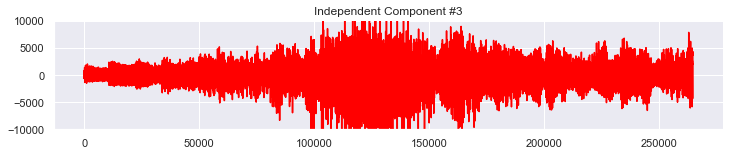

In [873]:
plt.figure(figsize=(12,2))
plt.title('Independent Component #3')
plt.plot((dfRec['Column 3'].values*10000).astype('int16'), c="red")
plt.ylim(-10000, 10000)
plt.show()

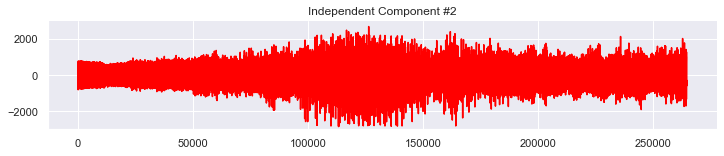

In [874]:
plt.figure(figsize=(12,2))
plt.title('Independent Component #2')
plt.plot((dfRec['Column 2'].values*10000).astype('int16'), c="red")
plt.ylim(-3000, 3000)
plt.show()

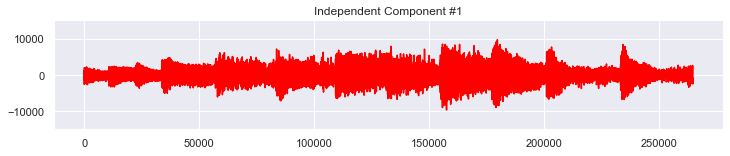

In [875]:
plt.figure(figsize=(12,2))
plt.title('Independent Component #1')
plt.plot((dfRec['Column 1'].values*10000).astype('int16'), c="red")
plt.ylim(-15000, 15000)
plt.show()

In [876]:
from scipy.io import wavfile
# Converting to int, mapping the appropriate range, and increasing the volume a little bit
result_signal_1_int = np.int16(dfRec['Column 1'].values*10000)
result_signal_2_int = np.int16(dfRec['Column 2'].values*50000)
result_signal_3_int = np.int16(dfRec['Column 3'].values*10000)
# Writing wave files
wavfile.write("result_signal_1.wav", fs, result_signal_1_int)
wavfile.write("result_signal_2.wav", fs, result_signal_2_int)
wavfile.write("result_signal_3.wav", fs, result_signal_3_int)

In [877]:
IPython.display.Audio("result_signal_3.wav")

In [878]:
IPython.display.Audio("result_signal_2.wav")

In [879]:
IPython.display.Audio("result_signal_1.wav")

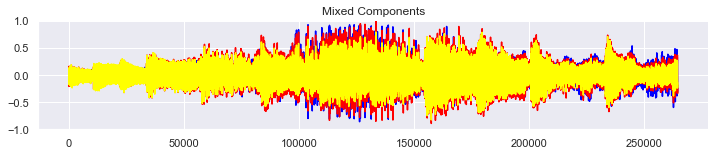

In [886]:
## Mixture Plot
plt.figure(figsize=(12,2))
plt.title('Mixed Components')
plt.plot(Xmix[0], c="blue")
plt.plot(Xmix[2], c="red")
plt.plot(Xmix[1], c="yellow")
plt.ylim(-1,1)
plt.show()

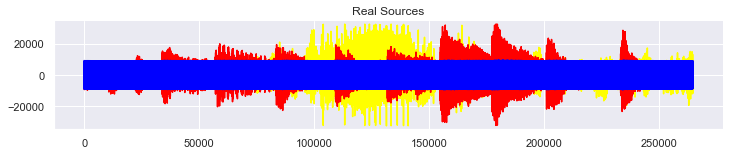

In [887]:
## Real Sources
plt.figure(figsize=(12,2))
plt.title('Real Sources')
plt.plot(X[:,0], c="yellow")
plt.plot(X[:,2], c="red")
plt.plot(X[:,1], c="blue")
plt.ylim(-35000,35000)
plt.show()

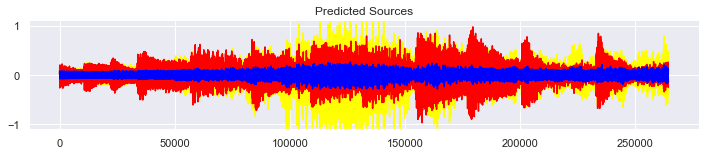

In [889]:
## Predicted Sources
plt.figure(figsize=(12,2))
plt.title('Predicted Sources')
plt.plot(Xrec[2], c="yellow")
plt.plot(Xrec[0],c = "red")
plt.plot(Xrec[1], c="blue")
plt.ylim(-1.1,1.1)
plt.show()

## Part 5

In [96]:
from sklearn.decomposition import FastICA

In [97]:
Fica = FastICA(3)

In [100]:
seperatedSounds = Fica.fit_transform(Xmix.T)

## Part 6

In [101]:
seperatedSounds

array([[ 6.54763256e-04,  6.32990544e-07,  1.57604522e-05],
       [ 7.11615432e-04, -1.11885583e-06,  1.90323341e-04],
       [ 6.14567805e-04,  1.97189142e-06,  3.59438027e-04],
       ...,
       [ 3.69191547e-04,  2.74353254e-03,  1.93751548e-03],
       [ 3.79618009e-04,  2.80266164e-03,  2.05982995e-03],
       [ 5.08047180e-04,  2.84448342e-03,  2.17534140e-03]])

In [102]:
result_signal_1 = seperatedSounds[:,0]
result_signal_2 = seperatedSounds[:,1]
result_signal_3 = seperatedSounds[:,2]

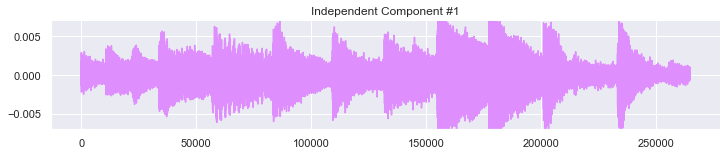

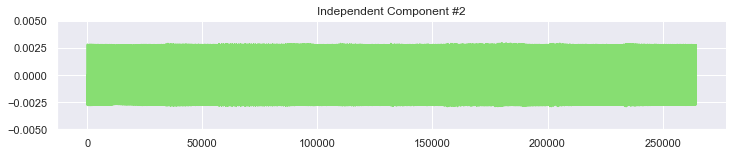

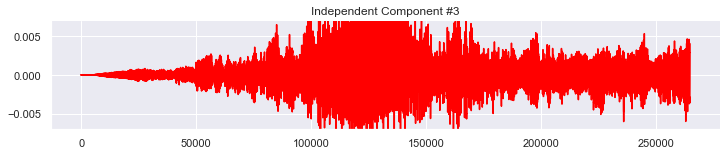

In [719]:
# Independent Component #1
plt.figure(figsize=(12,2))
plt.title('Independent Component #1')
plt.plot(result_signal_1, c="#df8efd")
plt.ylim(-0.007, 0.007)
plt.show()

# Independent Component #2
plt.figure(figsize=(12,2))
plt.title('Independent Component #2')
plt.plot(result_signal_2, c="#87de72")
plt.ylim(-0.0050, 0.0050)
plt.show()

# Independent Component #3
plt.figure(figsize=(12,2))
plt.title('Independent Component #3')
plt.plot(result_signal_3, c="red")
plt.ylim(-0.007, 0.007)
plt.show()


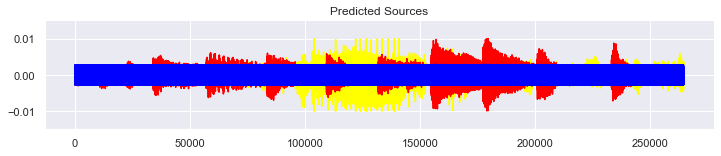

In [107]:
plt.figure(figsize=(12,2))
plt.title('Predicted Sources')
plt.plot(result_signal_2,c = "yellow")
plt.plot(result_signal_1, c="red")
plt.plot(result_signal_3, c="blue")
plt.ylim(-0.015,0.015)
plt.show()

In [720]:
from scipy.io import wavfile
# Converting to int, mapping the appropriate range, and increasing the volume a little bit
result_signal_1_int = np.int16(result_signal_1*32767*100)
result_signal_2_int = np.int16(result_signal_2*32767*100)
result_signal_3_int = np.int16(result_signal_3*32767*100)
# Writing wave files
wavfile.write("result_signal_1.wav", fs, result_signal_1_int)
wavfile.write("result_signal_2.wav", fs, result_signal_2_int)
wavfile.write("result_signal_3.wav", fs, result_signal_3_int)

In [721]:
IPython.display.Audio("result_signal_1.wav")

In [722]:
IPython.display.Audio("result_signal_2.wav")

In [723]:
IPython.display.Audio("result_signal_3.wav")

## Part 7

Fast ICA was faster than ICA and the results were good for both the algorithms. Other observations have been mentioned in the report.

# Question 2

## Part 1

In [8]:
PATH = ''

In [9]:
df = pd.read_csv(PATH + 'train.csv')

In [10]:
df.head()

Unnamed: 0     id  Gender      Customer Type  Age   Type of Travel  \
0           0  19556  Female     Loyal Customer   52  Business travel   
1           1  90035  Female     Loyal Customer   36  Business travel   
2           2  12360    Male  disloyal Customer   20  Business travel   
3           3  77959    Male     Loyal Customer   44  Business travel   
4           4  36875  Female     Loyal Customer   49  Business travel   

      Class  Flight Distance  Inflight wifi service  \
0       Eco              160                      5   
1  Business             2863                      1   
2       Eco              192                      2   
3  Business             3377                      0   
4       Eco             1182                      2   

   Departure/Arrival time convenient  ...  Inflight entertainment  \
0                                  4  ...                       5   
1                                  1  ...                       4   
2                                  0  ...                       2   
3                                  0  ...                       1   
4                                  3  ...                       2   

   On-board service  Leg room service  Baggage handling  Checkin service  \
0                 5                 5                 5                2   
1                 4                 4                 4                3   
2                 4                 1                 3                2   
3                 1                 1                 1                3   
4                 2                 2                 2                4   

   Inflight service  Cleanliness  Departure Delay in Minutes  \
0                 5            5                          50   
1                 4            5                           0   
2                 2            2                           0   
3                 1            4                           0   
4                 2            4                           0   

   Arrival Delay in Minutes             satisfaction  
0                      44.0                satisfied  
1                       0.0                satisfied  
2                       0.0  neutral or dissatisfied  
3                       6.0                satisfied  
4                      20.0                satisfied  

[5 rows x 25 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

In [12]:
df.describe()

Unnamed: 0             id           Age  Flight Distance  \
count  25976.000000   25976.000000  25976.000000     25976.000000   
mean   12987.500000   65005.657992     39.620958      1193.788459   
std     7498.769632   37611.526647     15.135685       998.683999   
min        0.000000      17.000000      7.000000        31.000000   
25%     6493.750000   32170.500000     27.000000       414.000000   
50%    12987.500000   65319.500000     40.000000       849.000000   
75%    19481.250000   97584.250000     51.000000      1744.000000   
max    25975.000000  129877.000000     85.000000      4983.000000   

       Inflight wifi service  Departure/Arrival time convenient  \
count           25976.000000                       25976.000000   
mean                2.724746                           3.046812   
std                 1.335384                           1.533371   
min                 0.000000                           0.000000   
25%                 2.000000                           2.000000   
50%                 3.000000                           3.000000   
75%                 4.000000                           4.000000   
max                 5.000000                           5.000000   

       Ease of Online booking  Gate location  Food and drink  Online boarding  \
count            25976.000000   25976.000000    25976.000000     25976.000000   
mean                 2.756775       2.977094        3.215353         3.261665   
std                  1.412951       1.282133        1.331506         1.355536   
min                  0.000000       1.000000        0.000000         0.000000   
25%                  2.000000       2.000000        2.000000         2.000000   
50%                  3.000000       3.000000        3.000000         4.000000   
75%                  4.000000       4.000000        4.000000         4.000000   
max                  5.000000       5.000000        5.000000         5.000000   

       Seat comfort  Inflight entertainment  On-board service  \
count  25976.000000            25976.000000      25976.000000   
mean       3.449222                3.357753          3.385664   
std        1.320090                1.338299          1.282088   
min        1.000000                0.000000          0.000000   
25%        2.000000                2.000000          2.000000   
50%        4.000000                4.000000          4.000000   
75%        5.000000                4.000000          4.000000   
max        5.000000                5.000000          5.000000   

       Leg room service  Baggage handling  Checkin service  Inflight service  \
count      25976.000000      25976.000000     25976.000000      25976.000000   
mean           3.350169          3.633238         3.314175          3.649253   
std            1.318862          1.176525         1.269332          1.180681   
min            0.000000          1.000000         1.000000          0.000000   
25%            2.000000          3.000000         3.000000          3.000000   
50%            4.000000          4.000000         3.000000          4.000000   
75%            4.000000          5.000000         4.000000          5.000000   
max            5.000000          5.000000         5.000000          5.000000   

        Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  
count  25976.000000                 25976.00000              25893.000000  
mean       3.286226                    14.30609                 14.740857  
std        1.319330                    37.42316                 37.517539  
min        0.000000                     0.00000                  0.000000  
25%        2.000000                     0.00000                  0.000000  
50%        3.000000                     0.00000                  0.000000  
75%        4.000000                    12.00000                 13.000000  
max        5.000000                  1128.00000               1115.000000

In [13]:
for i in df.columns:
    print(i,'==>',len(np.unique(df[i])))

Unnamed: 0 ==> 25976
id ==> 25976
Gender ==> 2
Customer Type ==> 2
Age ==> 75
Type of Travel ==> 2
Class ==> 3
Flight Distance ==> 3281
Inflight wifi service ==> 6
Departure/Arrival time convenient ==> 6
Ease of Online booking ==> 6
Gate location ==> 5
Food and drink ==> 6
Online boarding ==> 6
Seat comfort ==> 5
Inflight entertainment ==> 6
On-board service ==> 6
Leg room service ==> 6
Baggage handling ==> 5
Checkin service ==> 5
Inflight service ==> 6
Cleanliness ==> 6
Departure Delay in Minutes ==> 313
Arrival Delay in Minutes ==> 321
satisfaction ==> 2


In [14]:
## Dropping Unnamed: 0 column (No useful information)

In [15]:
df.drop(['Unnamed: 0'], axis = 1,inplace = True)

In [16]:
## Encoding Columns like 'Gender', 'Customer Type', etc.
## All the columns which were selected for this purpose had less than 8 unique values.

In [17]:
from sklearn.preprocessing import LabelEncoder

In [18]:
encoder = LabelEncoder()

In [19]:
df['Gender'] = encoder.fit_transform(df['Gender'])

In [20]:
df['Customer Type'] = encoder.fit_transform(df['Customer Type'])

In [21]:
df['Type of Travel'] = encoder.fit_transform(df['Type of Travel'])

In [22]:
df['Class'] = encoder.fit_transform(df['Class'])

In [23]:
df['satisfaction'] = encoder.fit_transform(df['satisfaction'])

In [24]:
df.head()

id  Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0  19556       0              0   52               0      1              160   
1  90035       0              0   36               0      0             2863   
2  12360       1              1   20               0      1              192   
3  77959       1              0   44               0      0             3377   
4  36875       0              0   49               0      1             1182   

   Inflight wifi service  Departure/Arrival time convenient  \
0                      5                                  4   
1                      1                                  1   
2                      2                                  0   
3                      0                                  0   
4                      2                                  3   

   Ease of Online booking  ...  Inflight entertainment  On-board service  \
0                       3  ...                       5                 5   
1                       3  ...                       4                 4   
2                       2  ...                       2                 4   
3                       0  ...                       1                 1   
4                       4  ...                       2                 2   

   Leg room service  Baggage handling  Checkin service  Inflight service  \
0                 5                 5                2                 5   
1                 4                 4                3                 4   
2                 1                 3                2                 2   
3                 1                 1                3                 1   
4                 2                 2                4                 2   

   Cleanliness  Departure Delay in Minutes  Arrival Delay in Minutes  \
0            5                          50                      44.0   
1            5                           0                       0.0   
2            2                           0                       0.0   
3            4                           0                       6.0   
4            4                           0                      20.0   

   satisfaction  
0             1  
1             1  
2             0  
3             1  
4             1  

[5 rows x 24 columns]

In [26]:
## Removing Null values from Arrival Delay in Minutes column
## Only a few rows are missing.
df.dropna(inplace = True)

In [27]:
df.describe()

id        Gender  Customer Type           Age  \
count   25893.000000  25893.000000   25893.000000  25893.000000   
mean    65021.974858      0.493029       0.184683     39.621983   
std     37606.098635      0.499961       0.388048     15.134224   
min        17.000000      0.000000       0.000000      7.000000   
25%     32209.000000      0.000000       0.000000     27.000000   
50%     65344.000000      0.000000       0.000000     40.000000   
75%     97623.000000      1.000000       0.000000     51.000000   
max    129877.000000      1.000000       1.000000     85.000000   

       Type of Travel         Class  Flight Distance  Inflight wifi service  \
count    25893.000000  25893.000000     25893.000000           25893.000000   
mean         0.305604      0.592747      1193.753254               2.723709   
std          0.460672      0.623777       998.626779               1.334711   
min          0.000000      0.000000        31.000000               0.000000   
25%          0.000000      0.000000       414.000000               2.000000   
50%          0.000000      1.000000       849.000000               3.000000   
75%          1.000000      1.000000      1744.000000               4.000000   
max          1.000000      2.000000      4983.000000               5.000000   

       Departure/Arrival time convenient  Ease of Online booking  ...  \
count                       25893.000000            25893.000000  ...   
mean                            3.046422                2.755996  ...   
std                             1.532971                1.412552  ...   
min                             0.000000                0.000000  ...   
25%                             2.000000                2.000000  ...   
50%                             3.000000                3.000000  ...   
75%                             4.000000                4.000000  ...   
max                             5.000000                5.000000  ...   

       Inflight entertainment  On-board service  Leg room service  \
count            25893.000000      25893.000000      25893.000000   
mean                 3.356969          3.385587          3.349786   
std                  1.338643          1.282033          1.319045   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                  5.000000          5.000000          5.000000   

       Baggage handling  Checkin service  Inflight service   Cleanliness  \
count      25893.000000     25893.000000      25893.000000  25893.000000   
mean           3.632681         3.313907          3.648824      3.285521   
std            1.176220         1.269138          1.180650      1.319355   
min            1.000000         1.000000          0.000000      0.000000   
25%            3.000000         3.000000          3.000000      2.000000   
50%            4.000000         3.000000          4.000000      3.000000   
75%            5.000000         4.000000          5.000000      4.000000   
max            5.000000         5.000000          5.000000      5.000000   

       Departure Delay in Minutes  Arrival Delay in Minutes  satisfaction  
count                25893.000000              25893.000000  25893.000000  
mean                    14.225080                 14.740857      0.438922  
std                     37.185919                 37.517539      0.496265  
min                      0.000000                  0.000000      0.000000  
25%                      0.000000                  0.000000      0.000000  
50%                      0.000000                  0.000000      0.000000  
75%                     12.000000                 13.000000      1.000000  
max                   1128.000000               1115.000000      1.000000  

[8 rows x 24 columns]

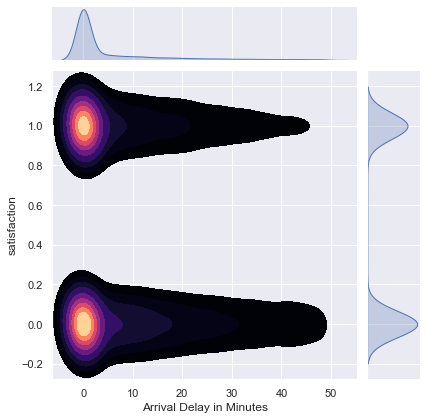

In [29]:
## Analysing  'Arrival Delay in Minutes' and 'satisfaction' columns
sns.jointplot(x = 'Arrival Delay in Minutes', y = 'satisfaction', data = df[df['Arrival Delay in Minutes'] < 50], kind = 'kde', fill = True, cmap='magma')

In [30]:
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:,-1])

In [31]:
from sklearn.model_selection import train_test_split as tts
X_train,X_test,y_train,y_test = tts(X,y)

## Part 2

In [32]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib

In [33]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [34]:
##decision tree classifier object
from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier()

In [35]:
#SFS object
sfs = SFS(estimator, k_features = 10, forward = True, floating = False, scoring = "accuracy")

## Part 3

In [36]:
sfs1 = sfs.fit(X_train, y_train)

In [37]:
for i in range(10):
    print("Features Selected:", sfs.subsets_[i+ 1]["feature_idx"])
    print("Accuracy:", sfs.subsets_[i + 1]["avg_score"])

Features Selected: (12,)
Accuracy: 0.786755293148486
Features Selected: (4, 12)
Accuracy: 0.8504558543366698
Features Selected: (4, 7, 12)
Accuracy: 0.8904681156579699
Features Selected: (4, 7, 10, 12)
Accuracy: 0.9219834643232151
Features Selected: (2, 4, 7, 10, 12)
Accuracy: 0.9281632179987603
Features Selected: (2, 4, 5, 7, 10, 12)
Accuracy: 0.937483877675351
Features Selected: (2, 4, 5, 7, 10, 12, 19)
Accuracy: 0.9446933250724792
Features Selected: (2, 4, 5, 7, 10, 12, 17, 19)
Accuracy: 0.9441781930955209
Features Selected: (2, 4, 5, 7, 9, 10, 12, 17, 19)
Accuracy: 0.9435087403355565
Features Selected: (1, 2, 4, 5, 7, 9, 10, 12, 17, 19)
Accuracy: 0.9407795686019998


Features Selected: (2, 4, 5, 7, 9, 10, 12, 15, 17, 19) --> Accuracy: 0.9431487911207134

In [38]:
print('Features Selected: ')
for i in sfs.subsets_[10]["feature_idx"]:
    print(str(i)+' ->',df.columns[i])

Features Selected: 
1 -> Gender
2 -> Customer Type
4 -> Type of Travel
5 -> Class
7 -> Inflight wifi service
9 -> Ease of Online booking
10 -> Gate location
12 -> Online boarding
17 -> Baggage handling
19 -> Inflight service


## Part 4

In [39]:
resultDic = {}
sfs = SFS(estimator, forward = True, floating = False, cv = 4,k_features=23)
sfs.fit(X_train, y_train)
resultDic['SFS'] = max(pd.DataFrame.from_dict(sfs.get_metric_dict()).T['avg_score'])

In [40]:
sbs = SFS(estimator, forward = False, floating = False, cv = 4)
sbs.fit(X_train, y_train)
resultDic['SBS'] = max(pd.DataFrame.from_dict(sbs.get_metric_dict()).T['avg_score'])

In [41]:
sffs = SFS(estimator, forward = True, floating = True, cv = 4,k_features=23)
sffs.fit(X_train, y_train)
resultDic['SFFS'] = max(pd.DataFrame.from_dict(sffs.get_metric_dict()).T['avg_score'])

In [42]:
sbfs = SFS(estimator, forward = False, floating = True, cv = 4)
sbfs.fit(X_train, y_train)
resultDic['SBFS'] = max(pd.DataFrame.from_dict(sbfs.get_metric_dict()).T['avg_score'])

In [69]:
ScoresSBS = pd.DataFrame.from_dict(sbs.get_metric_dict()).T[pd.DataFrame.from_dict(sbs.get_metric_dict()).T['avg_score'] == max(pd.DataFrame.from_dict(sbs.get_metric_dict()).T['avg_score'])][['cv_scores']]

In [82]:
ScoresSFS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T[pd.DataFrame.from_dict(sfs.get_metric_dict()).T['avg_score'] == max(pd.DataFrame.from_dict(sfs.get_metric_dict()).T['avg_score'])][['cv_scores']]

In [83]:
ScoresSBFS = pd.DataFrame.from_dict(sbfs.get_metric_dict()).T[pd.DataFrame.from_dict(sbfs.get_metric_dict()).T['avg_score'] == max(pd.DataFrame.from_dict(sbfs.get_metric_dict()).T['avg_score'])][['cv_scores']]

In [84]:
ScoresSFFS = pd.DataFrame.from_dict(sffs.get_metric_dict()).T[pd.DataFrame.from_dict(sffs.get_metric_dict()).T['avg_score'] == max(pd.DataFrame.from_dict(sffs.get_metric_dict()).T['avg_score'])][['cv_scores']]

In [88]:
print('SBS Scores')
ScoresSBS.values[0][0]

SBS Scores


array([0.94418126, 0.93944387, 0.94397528, 0.94004944])

In [110]:
print('SFS Scores')
ScoresSFS.values[0][0]

SFS Scores


array([0.94799176, 0.94670443, 0.94052523, 0.94515963])

In [90]:
print('SBFS Scores')
ScoresSBFS.values[0][0]

SBFS Scores


array([0.94562307, 0.94521112, 0.94356334, 0.94355171])

In [91]:
print('SFFS Scores')
ScoresSFFS.values[0][0]

SFFS Scores


array([0.94624099, 0.94665294, 0.94438723, 0.94561187])

In [43]:
resultDic

{'SFS': 0.9439722810282707,
 'SBS': 0.9419124639260432,
 'SFFS': 0.9457232549879764,
 'SBFS': 0.9444873095628182}

In [44]:
df_ = pd.DataFrame()
df_['Permutations'] = [i for i in resultDic]
df_['CV Scores'] = [resultDic[i] for i in resultDic]

In [45]:
df_

Permutations  CV Scores
0          SFS   0.943972
1          SBS   0.941912
2         SFFS   0.945723
3         SBFS   0.944487

<AxesSubplot:xlabel='Permutations', ylabel='CV Scores'>

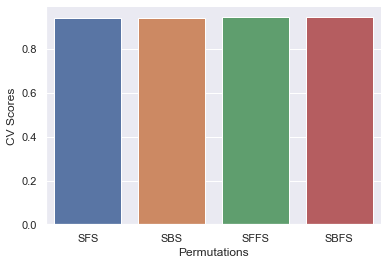

In [46]:
sns.barplot(x='Permutations', y = 'CV Scores', data = df_)

## Part 5 and Part 6

In [47]:
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

feature_idx  \
1                                               (12,)   
2                                             (4, 12)   
3                                          (4, 7, 12)   
4                                      (4, 7, 10, 12)   
5                                   (2, 4, 7, 10, 12)   
6                                (2, 4, 5, 7, 10, 12)   
7                            (2, 4, 5, 7, 10, 12, 19)   
8                        (2, 4, 5, 7, 10, 12, 17, 19)   
9                     (2, 4, 5, 7, 9, 10, 12, 17, 19)   
10                (2, 4, 5, 7, 9, 10, 12, 15, 17, 19)   
11             (2, 4, 5, 7, 8, 9, 10, 12, 15, 17, 19)   
12         (2, 4, 5, 7, 8, 9, 10, 12, 13, 15, 17, 19)   
13     (2, 4, 5, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20)   
14  (2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 19,...   
15  (2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18,...   
16  (2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17,...   
17  (2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, ...   
18  (0, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 1...   
19  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15...   
20  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15...   
21  (0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            cv_scores avg_score  \
1   [0.7839340885684861, 0.7894953656024717, 0.784...  0.786755   
2   [0.8453141091658084, 0.8516992790937178, 0.852...  0.850456   
3   [0.8908341915550978, 0.8910401647785788, 0.889...  0.890468   
4   [0.9200823892893923, 0.9186405767250257, 0.928...  0.921726   
5   [0.9246138002059732, 0.9256436663233779, 0.932...  0.927751   
6   [0.9390319258496396, 0.9338825952626159, 0.942...  0.938102   
7   [0.9464469618949537, 0.9435633367662204, 0.944...  0.943972   
8   [0.9462409886714727, 0.9382080329557158, 0.944...  0.943045   
9   [0.9441812564366633, 0.9382080329557158, 0.943...  0.941964   
10  [0.9415036045314109, 0.9394438722966014, 0.941...  0.939801   
11  [0.937178166838311, 0.9377960865087539, 0.9406...  0.937638   
12  [0.9328527291452111, 0.9328527291452111, 0.935...  0.934858   
13  [0.9367662203913492, 0.9336766220391349, 0.934...  0.935218   
14  [0.9367662203913492, 0.9349124613800206, 0.936...  0.936197   
15  [0.933264675592173, 0.9392378990731205, 0.9382...  0.937845   
16  [0.9375901132852729, 0.9392378990731205, 0.937...  0.936454   
17  [0.9314109165808445, 0.9349124613800206, 0.936...  0.933879   
18  [0.9363542739443872, 0.9353244078269825, 0.935...  0.934291   
19  [0.9375901132852729, 0.933264675592173, 0.9312...  0.933828   
20  [0.9394438722966014, 0.9291452111225541, 0.933...  0.933313   
21  [0.9357363542739444, 0.9270854788877446, 0.931...  0.930841   
22  [0.9305870236869207, 0.925849639546859, 0.9363...  0.930789   
23  [0.9307929969104016, 0.9237899073120495, 0.935...  0.928884   

                                        feature_names  ci_bound   std_dev  \
1                                               (12,)  0.004051  0.002527   
2                                             (4, 12)  0.004795  0.002991   
3                                          (4, 7, 12)  0.000792  0.000494   
4                                      (4, 7, 10, 12)  0.006167  0.003847   
5                                   (2, 4, 7, 10, 12)   0.00464  0.002895   
6                                (2, 4, 5, 7, 10, 12)  0.004902  0.003058   
7                            (2, 4, 5, 7, 10, 12, 19)  0.002719  0.001696   
8                        (2, 4, 5, 7, 10, 12, 17, 19)   0.00481  0.003001   
9                     (2, 4, 5, 7, 9, 10, 12, 17, 19)  0.003724  0.002323   
10                (2, 4, 5, 7, 9, 10, 12, 15, 17, 19)  0.002928  0.001826   
11             (2, 4, 5, 7, 8, 9, 10, 12, 15, 17, 19)  0.003304  0.002061   
12         (2, 4, 5, 7, 8, 9, 10, 12, 13, 15, 17, 19)  0.003458  0.002157   
13     (2, 4, 5, 7, 8, 9, 10, 12, 13, 15, 17, 19, 20)  0.001929

In [48]:
pd.DataFrame.from_dict(sbs.get_metric_dict()).T

feature_idx  \
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...   
21  (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15...   
20  (0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...   
19  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, ...   
18  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, ...   
17  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, ...   
16  (2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, 18,...   
15  (2, 3, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19...   
14  (2, 3, 4, 5, 7, 10, 11, 13, 14, 17, 18, 19, 20...   
13    (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19, 20, 22)   
12        (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19, 22)   
11            (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19)   
10               (2, 4, 5, 7, 10, 13, 14, 17, 18, 19)   
9                    (2, 4, 5, 7, 10, 13, 14, 17, 19)   
8                        (2, 4, 5, 7, 10, 13, 14, 17)   
7                            (2, 4, 5, 7, 10, 13, 14)   
6                                (2, 4, 5, 7, 10, 14)   
5                                    (2, 4, 5, 7, 10)   
4                                       (4, 5, 7, 10)   
3                                          (5, 7, 10)   
2                                             (7, 10)   
1                                                (7,)   

                                            cv_scores avg_score  \
23  [0.933264675592173, 0.9235839340885685, 0.9332...  0.929038   
22  [0.9355303810504635, 0.9351184346035015, 0.933...  0.935064   
21  [0.9363542739443872, 0.9365602471678682, 0.934...  0.935888   
20  [0.9345005149330587, 0.9375901132852729, 0.936...  0.937021   
19  [0.9363542739443872, 0.9359423274974253, 0.936...  0.936042   
18  [0.9382080329557158, 0.9365602471678682, 0.936...  0.937123   
17  [0.9373841400617919, 0.9345005149330587, 0.937...   0.93666   
16  [0.9396498455200823, 0.9375901132852729, 0.934...  0.936557   
15  [0.9390319258496396, 0.9316168898043254, 0.938...  0.937021   
14  [0.9421215242018538, 0.9309989701338826, 0.940...  0.938874   
13  [0.9447991761071061, 0.9314109165808445, 0.940...  0.939441   
12  [0.9406797116374871, 0.9338825952626159, 0.938...  0.938874   
11  [0.9390319258496396, 0.9349124613800206, 0.941...  0.938411   
10  [0.94129763130793, 0.9351184346035015, 0.93882...  0.937638   
9   [0.9419155509783728, 0.933470648815654, 0.9452...  0.939492   
8   [0.9423274974253347, 0.9386199794026776, 0.943...  0.941398   
7   [0.9439752832131822, 0.9386199794026776, 0.943...  0.940625   
6   [0.9441812564366633, 0.9394438722966014, 0.943...  0.941912   
5   [0.9398558187435634, 0.9355303810504635, 0.943...  0.939698   
4   [0.9227600411946447, 0.9198764160659114, 0.933...  0.924043   
3   [0.9083419155509783, 0.901750772399588, 0.9157...  0.907513   
2   [0.8228630278063852, 0.8160659114315139, 0.823...  0.820022   
1   [0.7431513903192585, 0.741503604531411, 0.7402...   0.74113   

                                        feature_names  ci_bound   std_dev  \
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.006916  0.004315   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...  0.001584  0.000988   
21  (0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15...  0.001029  0.000642   
20  (0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...  0.002618  0.001633   
19  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, ...  0.000765  0.000477   
18  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, ...  0.001079  0.000673   
17  (0, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, ...  0.002011  0.001255   
16  (2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 16, 17, 18,...  0.003537  0.002207   
15  (2, 3, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19...  0.005038  0.003143   
14  (2, 3, 4, 5, 7, 10, 11, 13, 14, 17, 18, 19, 20...  0.007388  0.004609   
13    (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19, 20, 22)  0.007926  0.004944   
12        (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19, 22)  0.005284  0.003297   
11            (2, 3, 4, 5, 7, 10, 13, 14, 17, 18, 19)  0.003901

In [49]:
pd.DataFrame.from_dict(sffs.get_metric_dict()).T

feature_idx  \
1                                               (12,)   
2                                             (4, 12)   
3                                          (4, 7, 12)   
4                                      (4, 7, 10, 12)   
5                                    (2, 4, 5, 7, 10)   
6                                (2, 4, 5, 7, 10, 19)   
7                            (2, 4, 5, 7, 10, 12, 19)   
8                        (2, 4, 5, 7, 10, 12, 17, 19)   
9                     (2, 4, 5, 7, 9, 10, 12, 17, 19)   
10               (2, 4, 5, 7, 12, 13, 14, 17, 19, 20)   
11            (1, 2, 4, 5, 7, 12, 13, 14, 17, 19, 20)   
12         (1, 2, 4, 5, 7, 9, 12, 13, 14, 17, 19, 20)   
13    (2, 4, 5, 7, 8, 10, 11, 13, 14, 17, 18, 19, 20)   
14  (2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 17, 18, 19,...   
15  (1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 17, 18, ...   
16  (1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, ...   
17  (1, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 16, 17, ...   
18  (1, 2, 3, 4, 5, 6, 7, 10, 11, 13, 14, 15, 16, ...   
19  (1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 1...   
20  (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15...   
21  (0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...   
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   

                                            cv_scores avg_score  \
1   [0.7839340885684861, 0.7894953656024717, 0.784...  0.786755   
2   [0.8453141091658084, 0.8516992790937178, 0.852...  0.850456   
3   [0.8908341915550978, 0.8910401647785788, 0.889...  0.890468   
4   [0.9200823892893923, 0.9186405767250257, 0.928...  0.921726   
5   [0.9398558187435634, 0.9355303810504635, 0.943...  0.939698   
6   [0.9425334706488157, 0.9392378990731205, 0.944...  0.942119   
7   [0.9466529351184346, 0.9433573635427395, 0.944...  0.944075   
8   [0.9464469618949537, 0.9386199794026776, 0.945...  0.943303   
9   [0.9447991761071061, 0.9384140061791967, 0.943...   0.94217   
10  [0.9462409886714727, 0.9466529351184346, 0.944...  0.945723   
11  [0.9443872296601442, 0.9421215242018538, 0.942...    0.9432   
12  [0.9398558187435634, 0.9398558187435634, 0.942...  0.940625   
13  [0.9429454170957775, 0.9349124613800206, 0.943...  0.940368   
14  [0.9398558187435634, 0.9349124613800206, 0.941...  0.938977   
15  [0.9421215242018538, 0.9314109165808445, 0.942...  0.938977   
16  [0.9427394438722966, 0.9299691040164778, 0.942...  0.937741   
17  [0.9398558187435634, 0.9305870236869207, 0.942...  0.937381   
18  [0.9410916580844491, 0.9338825952626159, 0.935...  0.937175   
19  [0.9398558187435634, 0.9345005149330587, 0.934...   0.93666   
20  [0.9388259526261586, 0.9345005149330587, 0.937...  0.936093   
21  [0.9361483007209063, 0.9351184346035015, 0.939...  0.936711   
22  [0.933264675592173, 0.9318228630278064, 0.9367...  0.934394   
23  [0.9297631307929969, 0.925437693099897, 0.9326...  0.928214   

                                        feature_names  ci_bound   std_dev  \
1                                               (12,)  0.004051  0.002527   
2                                             (4, 12)  0.004795  0.002991   
3                                          (4, 7, 12)  0.000792  0.000494   
4                                      (4, 7, 10, 12)  0.006167  0.003847   
5                                    (2, 4, 5, 7, 10)  0.004793   0.00299   
6                                (2, 4, 5, 7, 10, 19)  0.002962  0.001848   
7                            (2, 4, 5, 7, 10, 12, 19)  0.002662  0.001661   
8                        (2, 4, 5, 7, 10, 12, 17, 19)   0.00485  0.003026   
9                     (2, 4, 5, 7, 9, 10, 12, 17, 19)   0.00376  0.002345   
10               (2, 4, 5, 7, 12, 13, 14, 17, 19, 20)  0.001372  0.000856   
11            (1, 2, 4, 5, 7, 12, 13, 14, 17, 19, 20)  0.001307  0.000815   
12         (1, 2, 4, 5, 7, 9, 12, 13, 14, 17, 19, 20)  0.001785  0.001114   
13    (2, 4, 5, 7, 8, 10, 11, 13, 14, 17, 18, 19, 20)  0.005398

In [50]:
pd.DataFrame.from_dict(sbfs.get_metric_dict()).T

feature_idx  \
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...   
21  (0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...   
20  (0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...   
19  (0, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, ...   
18  (0, 2, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17,...   
17  (0, 2, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17,...   
16  (0, 2, 4, 5, 7, 10, 11, 13, 14, 15, 16, 17, 18...   
15  (2, 4, 5, 7, 10, 11, 13, 14, 15, 16, 17, 18, 1...   
14  (2, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19, 2...   
13   (2, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19, 20)   
12       (2, 4, 5, 7, 10, 13, 14, 16, 17, 18, 19, 20)   
11           (2, 4, 5, 7, 10, 12, 13, 14, 17, 19, 20)   
10               (2, 4, 5, 7, 12, 13, 14, 17, 19, 20)   
9                    (2, 4, 5, 7, 12, 13, 17, 19, 20)   
8                        (2, 4, 5, 7, 10, 12, 17, 19)   
7                            (2, 4, 5, 7, 10, 12, 19)   
6                                (2, 4, 5, 7, 10, 19)   
5                                    (2, 4, 5, 7, 10)   
4                                       (4, 5, 7, 10)   
3                                          (5, 7, 10)   
2                                             (7, 10)   
1                                                (7,)   

                                            cv_scores avg_score  \
23  [0.9316168898043254, 0.9225540679711638, 0.934...  0.929657   
22  [0.9375901132852729, 0.933264675592173, 0.9355...  0.935321   
21  [0.9382080329557158, 0.9349124613800206, 0.939...  0.936196   
20  [0.9377960865087539, 0.9369721936148301, 0.935...  0.935836   
19  [0.9423274974253347, 0.9340885684860968, 0.936...  0.937535   
18  [0.9353244078269825, 0.9353244078269825, 0.939...  0.936969   
17  [0.9419155509783728, 0.933264675592173, 0.9380...  0.937999   
16  [0.9390319258496396, 0.9342945417095777, 0.937...  0.937072   
15  [0.9398558187435634, 0.9246138002059732, 0.941...   0.93666   
14  [0.9400617919670443, 0.9312049433573636, 0.939...  0.937793   
13  [0.9365602471678682, 0.9345005149330587, 0.938...  0.937227   
12  [0.9394438722966014, 0.9340885684860968, 0.942...  0.938874   
11  [0.9441812564366633, 0.940885684860968, 0.9423...  0.941449   
10  [0.9456230690010299, 0.9452111225540679, 0.943...  0.944487   
9   [0.945417095777549, 0.9435633367662204, 0.9454...  0.943921   
8   [0.9468589083419156, 0.9369721936148301, 0.945...  0.942839   
7   [0.9470648815653965, 0.9435633367662204, 0.943...  0.944178   
6   [0.9425334706488157, 0.9392378990731205, 0.944...  0.942119   
5   [0.9398558187435634, 0.9355303810504635, 0.943...  0.939698   
4   [0.9227600411946447, 0.9198764160659114, 0.933...  0.924043   
3   [0.9083419155509783, 0.901750772399588, 0.9157...  0.907513   
2   [0.8228630278063852, 0.8160659114315139, 0.823...  0.820022   
1   [0.7431513903192585, 0.741503604531411, 0.7402...   0.74113   

                                        feature_names  ci_bound   std_dev  \
23  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  0.007255  0.004526   
22  (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14,...  0.002483  0.001549   
21  (0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15...  0.004749  0.002963   
20  (0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 1...  0.003146  0.001962   
19  (0, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16, ...  0.004827  0.003011   
18  (0, 2, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17,...  0.002679  0.001671   
17  (0, 2, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 17,...  0.004968  0.003099   
16  (0, 2, 4, 5, 7, 10, 11, 13, 14, 15, 16, 17, 18...  0.002766  0.001726   
15  (2, 4, 5, 7, 10, 11, 13, 14, 15, 16, 17, 18, 1...   0.01118  0.006975   
14  (2, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19, 2...  0.006151  0.003837   
13   (2, 4, 5, 7, 10, 11, 13, 14, 16, 17, 18, 19, 20)  0.002961  0.001847   
12       (2, 4, 5, 7, 10, 13, 14, 16, 17, 18, 19, 20)  0.004791  0.002989   
11           (2, 4, 5, 7, 10, 12, 13, 14, 17, 19, 20)  0.003386

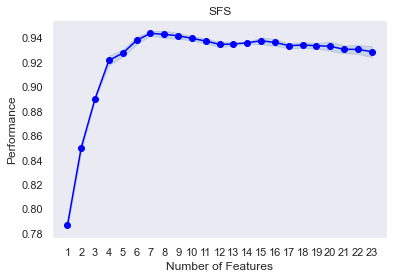

In [51]:
fig1 = plot_sfs(sfs.get_metric_dict())
plt.title('SFS')
plt.grid()
plt.show()

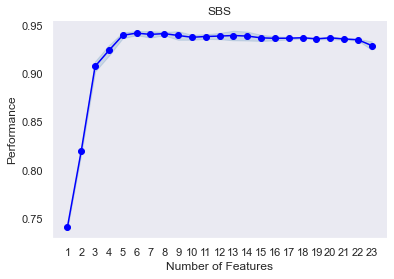

In [52]:
fig1 = plot_sfs(sbs.get_metric_dict())
plt.title('SBS')
plt.grid()
plt.show()

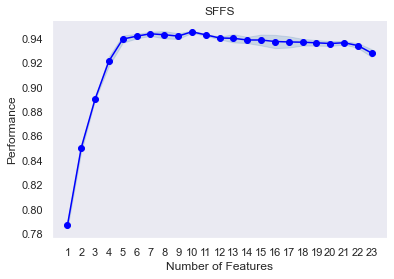

In [53]:
fig1 = plot_sfs(sffs.get_metric_dict())
plt.title('SFFS')
plt.grid()
plt.show()

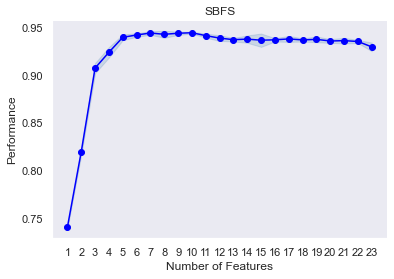

In [54]:
fig1 = plot_sfs(sbfs.get_metric_dict())
plt.title('SBFS')
plt.grid()
plt.show()

## Part 7

In [55]:
features = [i+1 for i in range(23)]
Results = {}
for feat in features:
    estimator = DecisionTreeClassifier()
    sfs = SFS(estimator, k_features = feat, forward = True, floating = False, scoring = "accuracy")
    sfs1 = sfs.fit(X_train, y_train)
    print("Number of features:",feat)
    print("k_features:", sfs1.k_feature_idx_)
    print("Score:", sfs1.k_score_)
    Results[feat] = sfs1.k_score_
    print()

Number of features: 1
k_features: (12,)
Score: 0.786755293148486

Number of features: 2
k_features: (4, 12)
Score: 0.8504558543366698

Number of features: 3
k_features: (4, 7, 12)
Score: 0.8904681156579699

Number of features: 4
k_features: (4, 7, 10, 12)
Score: 0.9219834643232151

Number of features: 5
k_features: (2, 4, 7, 10, 12)
Score: 0.9281632179987603

Number of features: 6
k_features: (2, 4, 5, 7, 10, 12)
Score: 0.9375868775483086

Number of features: 7
k_features: (2, 4, 5, 7, 10, 12, 19)
Score: 0.9448992717735261

Number of features: 8
k_features: (2, 4, 5, 7, 10, 12, 17, 19)
Score: 0.9437147002978203

Number of features: 9
k_features: (2, 4, 5, 7, 9, 10, 12, 17, 19)
Score: 0.9431482739332478

Number of features: 10
k_features: (2, 4, 5, 7, 9, 10, 12, 14, 17, 19)
Score: 0.9409340617808276

Number of features: 11
k_features: (1, 2, 4, 5, 7, 9, 10, 12, 13, 17, 19)
Score: 0.939183355687325

Number of features: 12
k_features: (1, 2, 4, 5, 7, 9, 10, 12, 13, 17, 19, 20)
Score: 0.93

In [56]:
df_ = pd.DataFrame()
df_['Number of Features'] = [i for i in Results]
df_['Score'] = [Results[i] for i in Results]

<AxesSubplot:xlabel='Number of Features', ylabel='Score'>

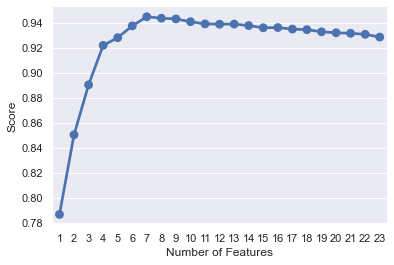

In [57]:
sns.pointplot(x = 'Number of Features',  y = 'Score', data = df_)